<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/uas_DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Latar Belakang**

#**1. Data Collection**

In [194]:
# Mount Google Drive (jika kamu menggunakan Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Import library yang dibutuhkan
import pandas as pd
import numpy as np

# Load dataset
file_path = "/content/drive/MyDrive/DM/salaries.csv"
df = pd.read_csv(file_path)

# Tampilkan informasi dasar
print("Jumlah baris & kolom:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Jumlah baris & kolom: (141566, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


#**2. Pre Processing**

In [195]:
# Cek missing values
print("Jumlah nilai kosong per kolom:\n", df.isnull().sum())

# Drop baris dengan missing values (jika jumlahnya sedikit)
df = df.dropna()

# Normalisasi format teks (lowercase untuk konsistensi)
df['job_title'] = df['job_title'].str.lower()
df['employee_residence'] = df['employee_residence'].str.upper()
df['company_location'] = df['company_location'].str.upper()

# Cek kembali info data
df.info()

# Pastikan data sudah bersih
df.head()

Jumlah nilai kosong per kolom:
 work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141566 entries, 0 to 141565
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           141566 non-null  int64 
 1   experience_level    141566 non-null  object
 2   employment_type     141566 non-null  object
 3   job_title           141566 non-null  object
 4   salary              141566 non-null  int64 
 5   salary_currency     141566 non-null  object
 6   salary_in_usd       141566 non-null  int64 
 7   employee_residence  141566 non-null  object
 8   remote_ratio        141566 non-null  int64 
 9   company_location    141566 non-null 

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,data quality analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,data quality analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,applied scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,applied scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,data scientist,291000,USD,291000,US,0,US,M


#**3. EDA**

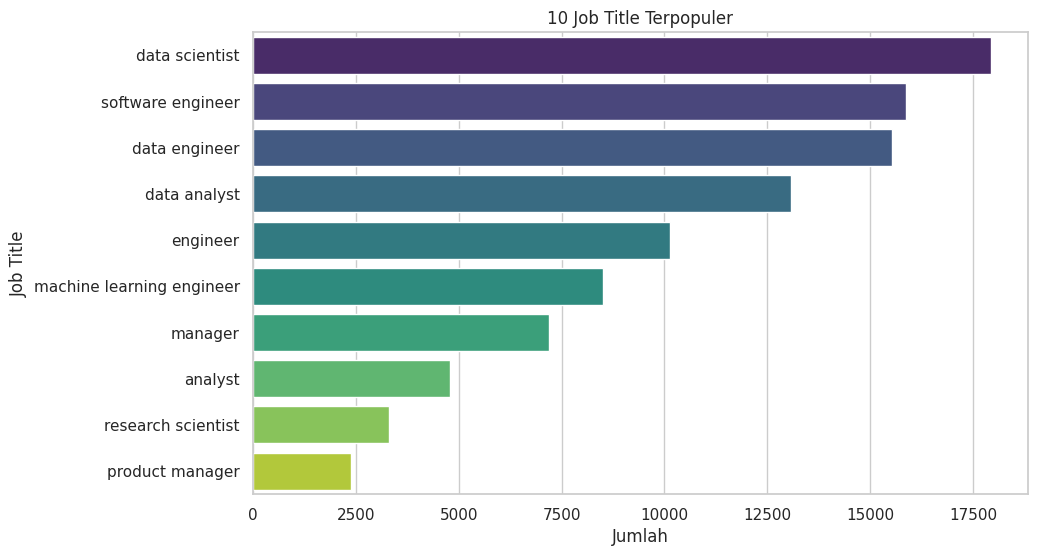

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah masing-masing job title
top_jobs = df['job_title'].value_counts().head(10)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette='viridis')
plt.title("10 Job Title Terpopuler")
plt.xlabel("Jumlah")
plt.ylabel("Job Title")
plt.show()

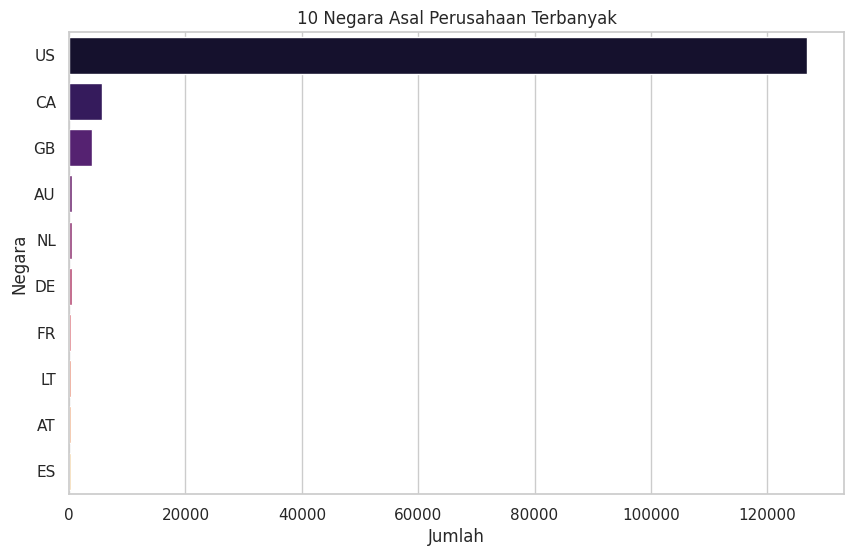

In [197]:
# Hitung distribusi lokasi perusahaan
top_countries = df['company_location'].value_counts().head(10)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')
plt.title("10 Negara Asal Perusahaan Terbanyak")
plt.xlabel("Jumlah")
plt.ylabel("Negara")
plt.show()

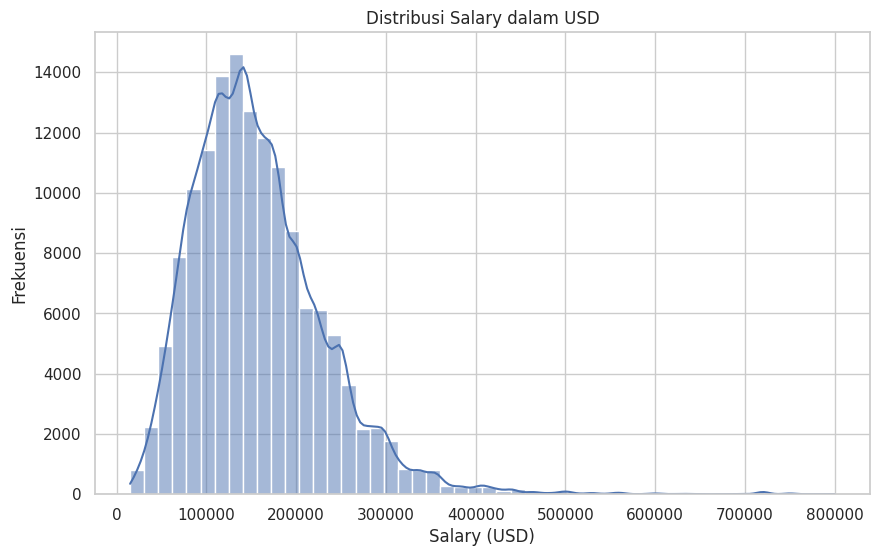

In [198]:
# Gaji dalam USD
plt.figure(figsize=(10,6))
sns.histplot(df['salary_in_usd'], bins=50, kde=True)
plt.title("Distribusi Salary dalam USD")
plt.xlabel("Salary (USD)")
plt.ylabel("Frekuensi")
plt.show()

In [220]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.8 MB/s eta 0:00:00


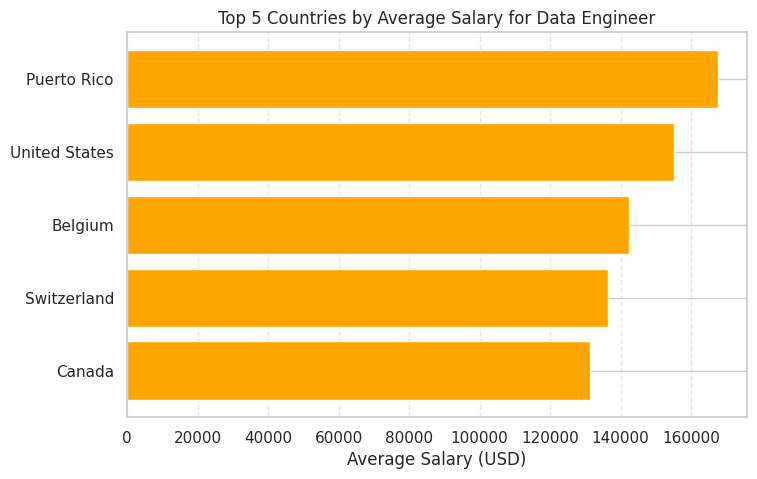

In [224]:
import pycountry

# Daftar alpha-2 country code dari negara berdaulat
sovereign_country_codes = {country.alpha_2 for country in pycountry.countries}

# Fungsi mapping ISO alpha-2 ke nama lengkap (dengan validasi negara berdaulat)
def get_country_name(code):
    country = pycountry.countries.get(alpha_2=code)
    return country.name if country else code

# Job title yang ingin dianalisis
job = 'data engineer'

# Filter hanya untuk negara berdaulat
filtered_df = df[
    (df['job_title'].str.lower() == job.lower()) &
    (df['company_location'].isin(sovereign_country_codes))
]

# Hitung rata-rata gaji dan ambil top 5
top_countries = (
    filtered_df
    .groupby('company_location')['salary_in_usd']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Mapping kode negara ke nama negara
top_countries.index = top_countries.index.map(get_country_name)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.barh(top_countries.index, top_countries.values, color="orange")
plt.xlabel("Average Salary (USD)")
plt.title(f"Top 5 Countries by Average Salary for {job.title()}")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

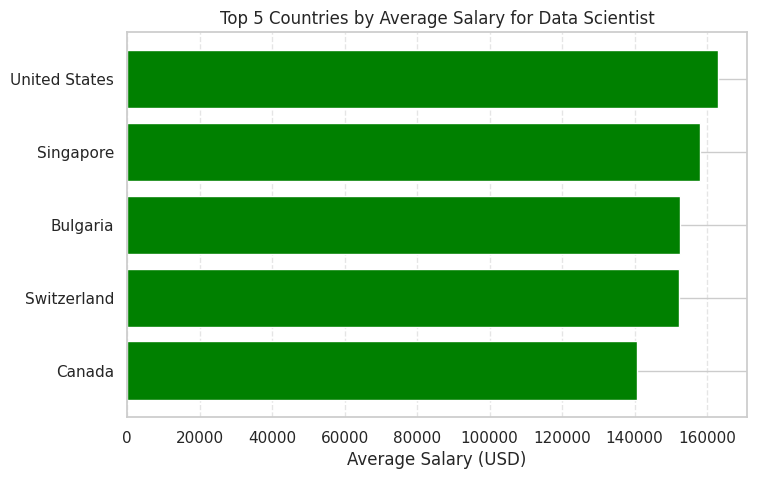

In [228]:
# Job title yang ingin dianalisis
job = 'data scientist'

# Filter hanya untuk negara berdaulat
filtered_df = df[
    (df['job_title'].str.lower() == job.lower()) &
    (df['company_location'].isin(sovereign_country_codes))
]

# Hitung rata-rata gaji dan ambil top 5
top_countries = (
    filtered_df
    .groupby('company_location')['salary_in_usd']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Mapping kode negara ke nama negara
top_countries.index = top_countries.index.map(get_country_name)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.barh(top_countries.index, top_countries.values, color="green")
plt.xlabel("Average Salary (USD)")
plt.title(f"Top 5 Countries by Average Salary for {job.title()}")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

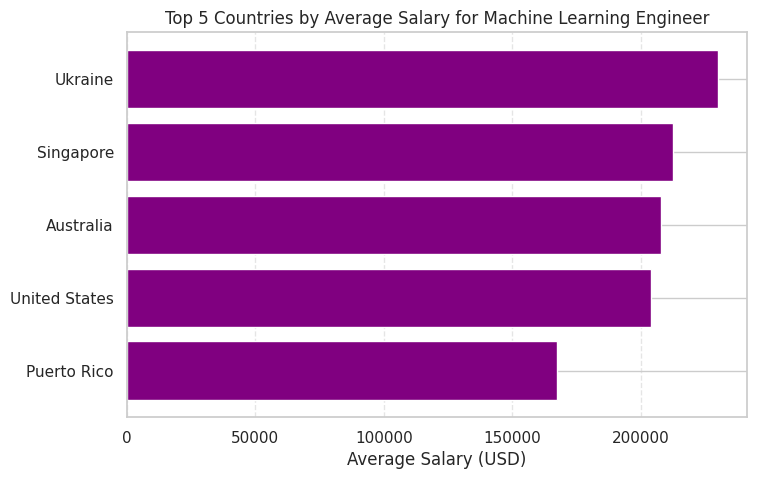

In [225]:
# Job title yang ingin dianalisis
job = 'machine learning engineer'

# Filter hanya untuk negara berdaulat
filtered_df = df[
    (df['job_title'].str.lower() == job.lower()) &
    (df['company_location'].isin(sovereign_country_codes))
]

# Hitung rata-rata gaji dan ambil top 5
top_countries = (
    filtered_df
    .groupby('company_location')['salary_in_usd']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Mapping kode negara ke nama negara
top_countries.index = top_countries.index.map(get_country_name)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.barh(top_countries.index, top_countries.values, color="purple")
plt.xlabel("Average Salary (USD)")
plt.title(f"Top 5 Countries by Average Salary for {job.title()}")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

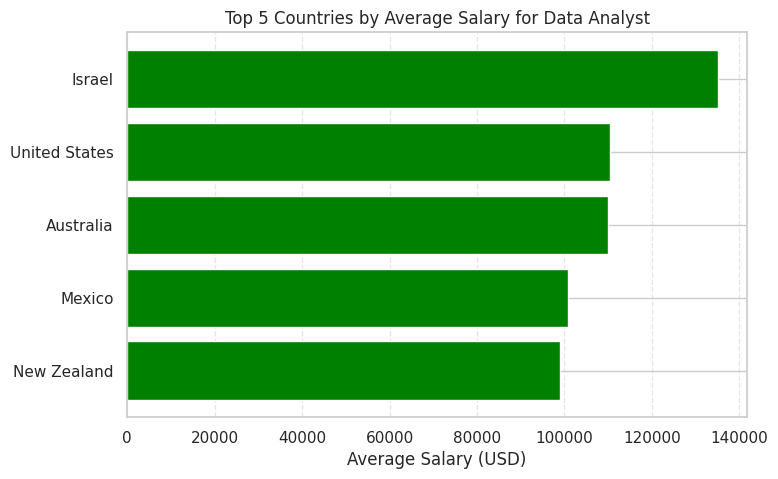

In [226]:
# Job title yang ingin dianalisis
job = 'data analyst'

# Filter hanya untuk negara berdaulat
filtered_df = df[
    (df['job_title'].str.lower() == job.lower()) &
    (df['company_location'].isin(sovereign_country_codes))
]

# Hitung rata-rata gaji dan ambil top 5
top_countries = (
    filtered_df
    .groupby('company_location')['salary_in_usd']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Mapping kode negara ke nama negara
top_countries.index = top_countries.index.map(get_country_name)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.barh(top_countries.index, top_countries.values, color="green")
plt.xlabel("Average Salary (USD)")
plt.title(f"Top 5 Countries by Average Salary for {job.title()}")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

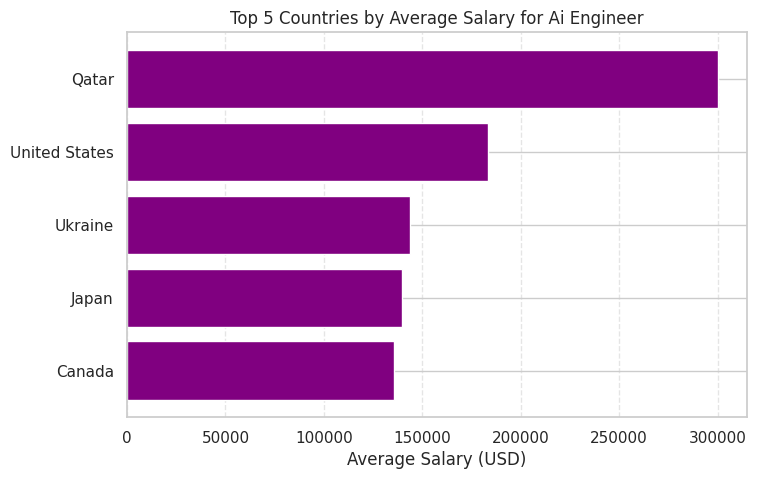

In [227]:
# Job title yang ingin dianalisis
job = 'ai engineer'

# Filter hanya untuk negara berdaulat
filtered_df = df[
    (df['job_title'].str.lower() == job.lower()) &
    (df['company_location'].isin(sovereign_country_codes))
]

# Hitung rata-rata gaji dan ambil top 5
top_countries = (
    filtered_df
    .groupby('company_location')['salary_in_usd']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Mapping kode negara ke nama negara
top_countries.index = top_countries.index.map(get_country_name)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.barh(top_countries.index, top_countries.values, color="purple")
plt.xlabel("Average Salary (USD)")
plt.title(f"Top 5 Countries by Average Salary for {job.title()}")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

#**4. Feature Engineering**

In [200]:
# Buat fitur baru: salary_level (low, medium, high)
df['salary_level'] = pd.qcut(df['salary_in_usd'], q=3, labels=['low', 'medium', 'high'])

# Cek distribusi
df['salary_level'].value_counts()

,count
salary_level,
low,48635
high,46958
medium,45973


In [201]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['salary_norm'] = scaler.fit_transform(df[['salary_in_usd']])

In [202]:
from sklearn.preprocessing import LabelEncoder

# Inisialisasi label encoder
le = LabelEncoder()

# Encode semua kolom kategorikal utama
categorical_cols = ['job_title', 'company_location', 'employment_type', 'experience_level', 'remote_ratio']

for col in categorical_cols:
    df[col + '_enc'] = le.fit_transform(df[col])

#**5. Encode & Split**

In [203]:
# Fitur yang digunakan (hasil encoding)
features = ['job_title_enc', 'company_location_enc', 'employment_type_enc',
            'experience_level_enc', 'remote_ratio', 'work_year']

# Target
target = 'salary_level'

X = df[features]
y = df[target]

In [204]:
from sklearn.model_selection import train_test_split

# Split data 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cek ukuran
X_train.shape, X_test.shape

((113252, 6), (28314, 6))

In [187]:
from sklearn.model_selection import train_test_split

# Bagi data menjadi 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#**6. Model Training**

In [205]:
# Import model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [206]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [207]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [208]:
# Evaluasi akurasi dan classification report
lr_acc = accuracy_score(y_test, y_pred_lr)
rf_acc = accuracy_score(y_test, y_pred_rf)

print("Logistic Regression Accuracy:", lr_acc)
print("Random Forest Accuracy:", rf_acc)

print("\nClassification Report - Logistic Regression")
print(classification_report(y_test, y_pred_lr))

print("\nClassification Report - Random Forest")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Accuracy: 0.4907113088931271
Random Forest Accuracy: 0.5369781733418098

Classification Report - Logistic Regression
              precision    recall  f1-score   support

        high       0.49      0.60      0.54      9392
         low       0.56      0.58      0.57      9727
      medium       0.39      0.29      0.33      9195

    accuracy                           0.49     28314
   macro avg       0.48      0.49      0.48     28314
weighted avg       0.48      0.49      0.48     28314


Classification Report - Random Forest
              precision    recall  f1-score   support

        high       0.52      0.70      0.60      9392
         low       0.64      0.64      0.64      9727
      medium       0.41      0.27      0.32      9195

    accuracy                           0.54     28314
   macro avg       0.52      0.53      0.52     28314
weighted avg       0.52      0.54      0.52     28314



#**7. Visualisasi**

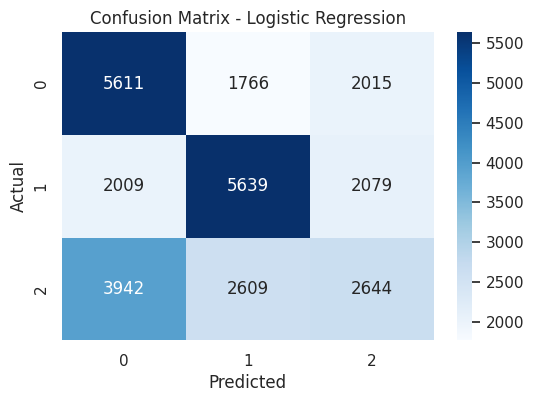

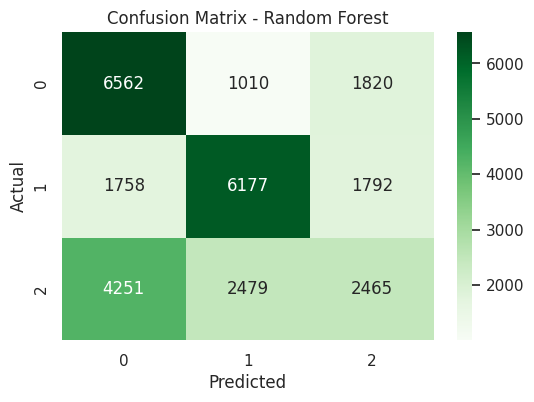

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix Logistic Regression
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion Matrix Random Forest
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

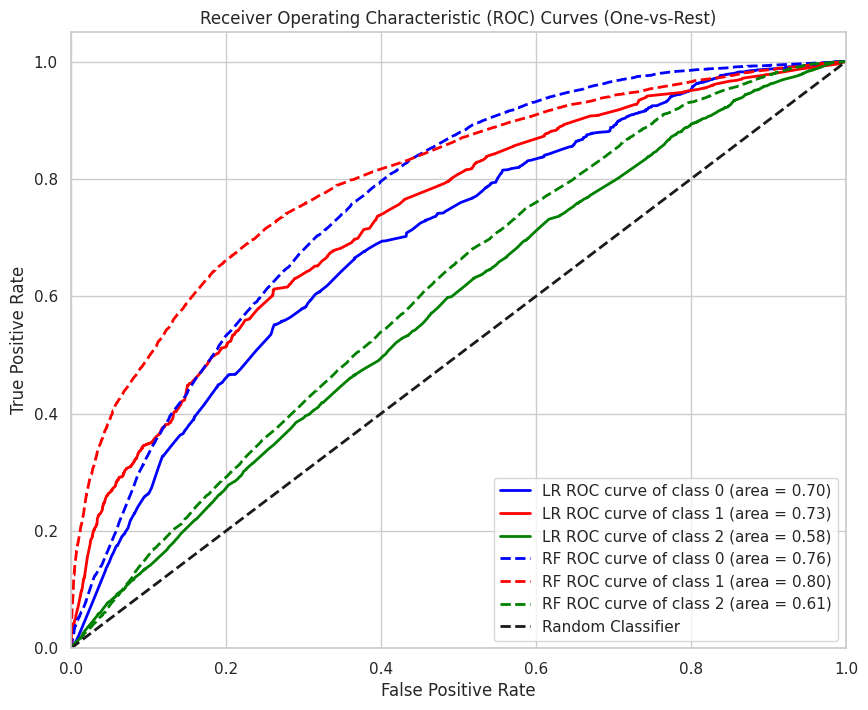


Logistic Regression OvR Macro AUC: 0.67
Logistic Regression OvR Weighted AUC: 0.67
Random Forest OvR Macro AUC: 0.72
Random Forest OvR Weighted AUC: 0.73


In [211]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target variable for OvR
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get prediction probabilities for each class
# Ensure models have predict_proba method (Logistic Regression and Random Forest do)
y_prob_lr = lr_model.predict_proba(X_test)
y_prob_rf = rf_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class (OvR)

# For Logistic Regression
fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()
for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bin[:, i], y_prob_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

# For Random Forest
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])


# Plot ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green'] # Colors for each class
lw = 2 # Line width

# Plot LR OvR ROC curves
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_lr[i], tpr_lr[i], color=color, lw=lw,
             label='LR ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc_lr[i]))

# Plot RF OvR ROC curves
for i, color in zip(range(n_classes), colors):
     plt.plot(fpr_rf[i], tpr_rf[i], color=color, linestyle='--', lw=lw,
             label='RF ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc_rf[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Random Classifier') # Diagonal random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# You can also calculate the macro and weighted average AUC
# macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
macro_roc_auc_ovr_lr = roc_auc_score(y_test, y_prob_lr, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_lr = roc_auc_score(y_test, y_prob_lr, multi_class="ovr", average="weighted")

macro_roc_auc_ovr_rf = roc_auc_score(y_test, y_prob_rf, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_rf = roc_auc_score(y_test, y_prob_rf, multi_class="ovr", average="weighted")


print(f"\nLogistic Regression OvR Macro AUC: {macro_roc_auc_ovr_lr:.2f}")
print(f"Logistic Regression OvR Weighted AUC: {weighted_roc_auc_ovr_lr:.2f}")
print(f"Random Forest OvR Macro AUC: {macro_roc_auc_ovr_rf:.2f}")
print(f"Random Forest OvR Weighted AUC: {weighted_roc_auc_ovr_rf:.2f}")